# Tutorial 1: Manifold Capacity Theory & Implementation
Run the cells below before you do anything else!

In [1]:
# Imports and pip installs
#### RUN THIS CELL FIRST ####

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
cvxopt.solvers.options['show_progress'] = False

# Part 0: Problem Setup

In lecture, we learned...

To develop some intuition for how this works, we'll translate the mean-field formulae from lecture into python code and use it to explore manifold capacity in a few simple settings. Later on, we'll use these tools to analyze the representations learned by neural networks trained to perform image classification.

We consider a collection of manifolds $\{M_\mu\}_{\mu=1}^P$ embedded in $\mathbb{R}^N$, each of which is represented by a point cloud $M^\mu = \{\mathbf{x}^\mu_i\}_{i=1}^{n_\mu}$. Each manifold can be viewed as a compact subset of a $D$-dimensional affine subspace of $\mathbb{R}^N$ with $D < N$, and as such we can represent a point on a manifold in terms of an orthonormal basis for this subspace:

$$\mathbf{x}^\mu = \sum_{i=1}^{D+1}s_i^\mu\mathbf{u}_i = \mathbf{x}_0^\mu + \sum_{i=1}^{D}s_i^\mu\mathbf{u}_i$$

This setup is visualized in the picture below:

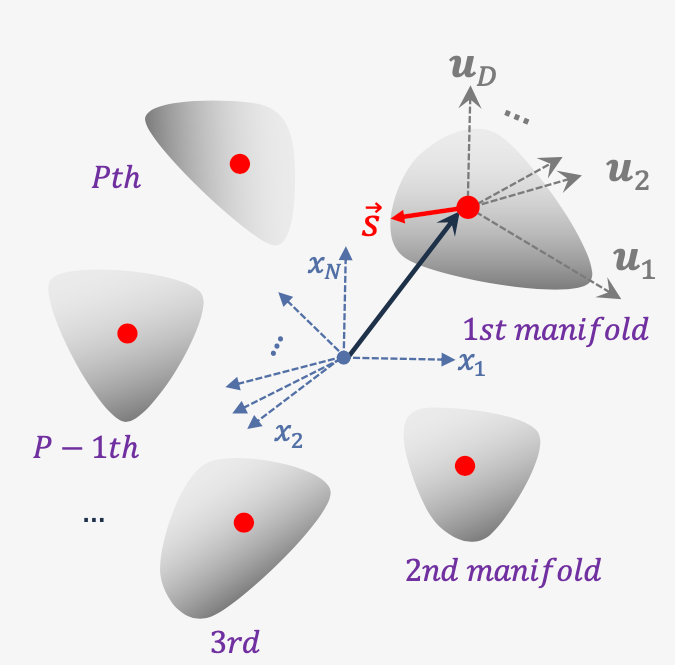

We use the notation $\vec{S} = (S_1,S_2,\ldots,S_{D+1}) \in \mathbb{R}^{D+1}$ to denote a point on a manifold in its $D+1$-dimensional basis, and $\mathcal{S} = \{\vec{S}_1,\vec{S}_2,\ldots,\vec{S}_n\}$ for the set of points associated to a manifold. Note that we need $D+1$ coordinates to describe $D$-dimensional subspace because it is not generally centered at the origin.

Given a set of manifolds $\{M_\mu\}$, we're interested in computing the following quantities for each:

1. **Manifold Capacity** $\alpha_M$: the maximum number of manifolds per neuron ($P/N$) that can be linearly separated in $\mathbb{R}^N$.
2. **Manifold Dimension** $D_M$: The dimension of the affine subspace containing the manifold.
3. **Manifold Radius** $R_M$: The "size" of the manifold in the ambient space.

In general these will be different for each $M$, since they may have different intrinsic dimensions/radii that inform how many we can efficiently pack into $\mathbb{R}^N$. In the first part of this tutorial we'll write some functions implementing the mean-field computation of $\alpha_M$, $D_M$, and $R_M$ given a collection of manifolds represented as point clouds. Later on, we'll use these tools to analyze the representations learned by neural networks and explore a capacity-inspired loss function for self-supervised representation learning. The theoretical underpinning is described in detail in [Classification and Geometry of General Perceptual Manifolds](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003), while the neural network experiments closely follow the analyses in [Separability and geometry of object manifolds in deep neural networks](https://www.nature.com/articles/s41467-020-14578-5) and [Learning Efficient Coding of Natural Images with Maximum Manifold Capacity Representations](https://arxiv.org/abs/2303.03307)

# Part I: Computing Manifold Capacity

Our collection of manifolds comes to us as a set of point clouds $\{X_1, \ldots, X_n\}$ where $X_k \in \mathbb{R}^{N \times P_k}$ ($P_k =$ number of points in manifold $k$). The first thing we'll implement is some basic **preprocessing** of each point cloud, which will make the capacity calculations a little easier. This consists of two steps:
1. Center all points across all manifolds about the global mean of all the points in $\mathbb{R}^N$: just like you would center your data before training a neural network.
2. For each manifold, compute a $D+1$-dimensional basis for the affine subspace it lives in, and express points on the manifold in this basis (i.e. the $\vec{S}$ notation used above)

For the manifold bases, we will follow the convention of the original capacity paper and set the $D+1$-th basis vector to be the manifold's center $\mathbf{c}$ (i.e. the mean of the point cloud for the manifold). We'll then express the remaining $1,\ldots,D$ orthonormal basis vectors relative to this center. The coordinates for the center $\mathbf{c}$ will be $\vec{C} = (0,0,\ldots,0,1)$, while the coordinates for any point $\vec{S}$ will be $\vec{S} = (S_1,S_2,\ldots,S_D,1)$. We 

## Coding: Normalization
Let's start with normalization. We want to do two things:
1. **Global centering**: described above; shift all points across all manifolds such that their global mean is zero.

2. **Local centering/normalization for each manifold**: to make downstream computations easier, we'll use "local" coordinates for each manifold. We want to independently shift each point cloud to have zero mean, and scale each point by the norm of its center location. In other words, for each point cloud we do: $$\mathbf{x}_i \mapsto \frac{\mathbf{x}_i - \mathbf{c}}{||\mathbf{c}||}, \quad \mathbf{c} = \frac{1}{P}\sum_{i=1}^{P}\mathbf{x}_i$$

In [87]:
def center_manifolds(X):
    """
    Preprocess the set of manifolds by centering all the points about the origin, then center and normalize
    the points of each manifold w.r.t to its center location/norm.
    
    Args:
        X: list[np.ndarray]: list of point clouds, each a numpy array of shape (N, P_i) where N is the
        dimensionality of the ambient space and P_i is the number of points in the i-th manifold.
        
    Returns:
        list[np.ndarray]: Preprocessed manifolds
        list[float]: List of norms of the centers of each manifold.
    """
    # If we have more than one manifold point cloud, 
    # compute the global mean vector across all point clouds
    # and center all the points about this global mean.
    if len(X) > 1:
        # Compute the mean across all manifolds
        X_global_mean = np.mean(np.concatenate(X, axis=1), axis=1, keepdims=True)

        # center all manifolds about the global mean
        X_centered = [x - X_global_mean for x in X]
    else:
        X_centered = X
    
    # Compute centers (means) for each manifold and center/normalize the points of each manifold around its center
    manifold_means = [np.mean(x, axis=1, keepdims=True) for x in X_centered]
    manifold_mean_norms = [np.linalg.norm(m) for m in manifold_means]
    X_normalized = [(x - m) / norm for x, m, norm in zip(X_centered, manifold_means, manifold_mean_norms)]
    
    return X_normalized, manifold_mean_norms

Next, we compute orthonormal bases for each centered/normalized manifold. There are two relevant cases:
1. $P_i \geq N$: there are more points than ambient dimensions, in which case the standard basis in $\mathbb{R}^N$ will suffice.

2. $P_i < N$: there are fewer points than ambient dimensions, in which case our point cloud vectors span an at-most $P_i$-dimensional subspace of $\mathbb{R}^N$. We want to compute an orthonormal basis $(\mathbf{e}_1,\ldots,\mathbf{e}_D)$ for this space and express the points in $X_i$ in those coordinates. We can use the [**QR decomposition**](https://en.wikipedia.org/wiki/QR_decomposition), which decomposes a matrix $A \in \mathbb{R}^{m \times n},$ with $m \geq n$ into $A = QR$, where $Q$ is an $m \times n$ matrix with orthonormal columns, and $R$ is an upper triangular $n \times n$ matrix. This is essentially just the [Gram-Schmidt orthonormalization](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) of the columns of $A$, and thankfully `np.linalg.qr` can do it for us.

In [88]:
def project_to_manifold_bases(X):
    """
    Compute an orthonormal basis for each manifold using QR decomposition. Express points on each manifold in this basis, and add 
    an additional dimension for the center of the manifold. Each point should have coordinates of the form (S_1, S_2, ..., S_D, 1) 
    where D is the dimension of the manifold, and the last coordinate is always 1 (for the center).

    Args:
        X: list[np.ndarray]: list of point clouds, each a numpy array of shape (N, P_i). These should be the preprocessed manifold data.

    Returns:
        list[np.ndarray]: list of point clouds in their new orthonormal bases.
    """
    X_new_basis = []
    for x in X:
        # Get dimensions/number of points in ambient space
        N, P_i = x.shape
        if N > P_i:
            # Perform QR decomposition
            Q, R = np.linalg.qr(x,mode='reduced') # Q has shape 
            x = np.matmul(Q.T, x)
        # add the center coordinate (1) as an aditional dimension for each point
        N, new_dim = x.shape
        x = np.concatenate((x, np.ones((1, new_dim))), axis=0)
        # record the coordinates in the new basis
        X_new_basis.append(x)
    return X_new_basis

# The theory section...

Now we're ready to do some capacity calculations! As discussed in lecture, we can compute these quantities using the mean field theory for manifold capacity introduced in [this paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003). Capacity generally depends on the desired sepration margin $\kappa$ between manifolds, though we usually only consider the zero-margin capacity $\kappa = 0$ (i.e. a dichotomy of the manifolds is "just barely separable"). Despite this, we will implement our code for the general case $\kappa \geq 0$.

The key result from mean field theory is the following expression for the manifold capacity:

$$\alpha_M^{-1} = \langle F(\vec{T}) \rangle_{\vec{T}}$$

where the average is performed over random $D+1$-dimensional vectors $\vec{T} \sim \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$, and

$$\begin{equation}F(\vec{T}) = \min_{\vec{V}}\{ ||\vec{V} - \vec{T}||^2 \, | \, \vec{V}\cdot\vec{S} - \kappa \geq 0, \; \forall \vec{S} \in \mathcal{S}\}.\end{equation}$$

Recall that $\mathcal{S}$ simply denotes the points on the manifold in terms of their $D+1$-dimensional coordinates.

This seems a bit tricky to solve, but thankfully there useful tools. If we squint our eyes a bit we can immediately recognize that our problem resembles the [standard form](https://en.wikipedia.org/wiki/Optimization_problem#Continuous_optimization_problem) for constrained optimization:

$$
\begin{align*}
\text{min}&\text{imize } f(\mathbf{x}) \\
\text{sub}&\text{ject to } \\
&g_i(\mathbf{x}) \leq 0 \\
&h_j(\mathbf{x}) = 0
\end{align*}
$$

where $i=1,\ldots,m$ and $j=1,\ldots,\ell$ enumerate the constraint functions. In our case, we have $|\mathcal{S}|$ constraints for each $\vec{S}_i$ in the manifold:

$$
\begin{align*}
f(\vec{V}) &= ||\vec{V} - \vec{T}||^2 \\
g_i(\vec{V}) &= -\vec{S}_i\cdot\vec{V} + \kappa, \; i=1,\ldots,|\mathcal{S}|
\end{align*}
$$

Before we get into solving this, we note there are two distinct cases, one of which leads to an easy solution:

1. $\vec{T} \cdot \vec{S} - \kappa \geq 0 \; \forall \vec{S} \in \mathcal{S}$ -- in this case $\vec{V} = \vec{T}$ is a valid and optimal solution! We can check for this case by checking $\min\{\vec{T}\cdot\vec{S} \,| \, \vec{S} \in \mathcal{S}\} - \kappa \geq 0$.
2. The opposite of the above, i.e. $\vec{T} \cdot \vec{S} - \kappa < 0$ for some $\vec{S}$. In this case, we'll actually need to solve the optimization problem.

### The KKT conditions for constrained optimization
As discussed in the [capacity paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003), the [Karush-Kuhn-Tucker (KKT) conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) are a helpful way to characterize the solution $\vec{V}^\ast$ to the optimization problem. We're interested in finding a saddle point of the following [Lagrangian function](https://en.wikipedia.org/wiki/Lagrange_multiplier):

$$
\mathcal{L}(\vec{V},\boldsymbol{\lambda}) = f(\mathbf{x}) + \sum_{i=1}^{|\mathcal{S}|}\lambda_i g_i(\mathbf{x}).
$$

The KKT conditions state that the solution $(\vec{V}^\ast,\boldsymbol{\lambda}^\ast)$ satisfies the following conditions:

$$
\begin{align*}
&\nabla f(\vec{V}^\ast) + \sum_{i=1}^{|\mathcal{S}|}\lambda_i^\ast \nabla g_i(\vec{V}^\ast) = 0 \\
&g_i(\vec{V}^\ast) \leq 0 \\
&\lambda_i^\ast \geq 0 \\
&\lambda_i^\ast g_i(\vec{V}^\ast) = 0
\end{align*}
$$
where last three hold for all $i=1,\ldots,|\mathcal{S}|$. To make the analysis simpler, we consider minimizing $\tilde{f}(\vec{V}) = \frac{1}{2}||\vec{V}||^2 - \vec{V}\cdot\vec{T}$ instead of $f(\vec{V}) = ||\vec{V}-\vec{T}||^2$, because they both have the same optimum (**exercise**: convince yourself why we can do this). The first KKT condition then reads:

$$\vec{V}^\ast - \vec{T} - \sum_{i=1}^{|\mathcal{S}|}\lambda_i^\ast \vec{S}_i = 0,$$

which we can rearrange as

$$\vec{V}^\ast = \vec{T} + \sum_{i=1}^{|\mathcal{S}|}\lambda_i^\ast \vec{S}_i.$$

If we now define $\Lambda = \sum \lambda_i^\ast$ and $\tilde{\lambda}_i^\ast = \lambda_i^\ast/\Lambda$, we can write:

$$ \vec{V}^\ast = \vec{T} + \Lambda \sum_{i=1}^{|\mathcal{S}|}\tilde{\lambda}_i^\ast \vec{S}_i = \vec{V}^\ast + \Lambda \tilde{S}(\vec{T})$$

Why have we done this? If you look closely, you'll notice $\tilde{S}(\vec{T})$ is on the **convex hull** of our manifold. We call this an **anchor point** of the manifold for the sample $\vec{T}$. What the KKT conditions tell us is that we can decompose our solution $\vec{V}^\ast$ into $\vec{T}$ and an anchor point on the convex hull scaled by $\Lambda$. These anchor points turn out to be exactly what we need to compute the manifold capacity, radius, and dimension!

First, let's make a few useful observations:
1. Our decomposition of $\vec{V}^\ast$ allows us to write $$ F(\vec{T}) = ||\Lambda\tilde{S}(\vec{T})||^2, $$ directly tying the calculation of manifold capacity $\alpha_M^{-1} = \langle F(\vec{T}) \rangle$ to the calculation of these anchor points.

2. We wrote our optimization problem with $|\mathcal{S}|$ constraints, but we could have written it with just **one** constraint defined by the **support function** $$g_\mathcal{S}(\vec{V}) = \min_{\vec{S} \in \mathcal{S}} \vec{V}\cdot \vec{S} \implies \text{constraint: } g_\mathcal{S}(\vec{V}) - \kappa \geq 0.$$ This looks simpler but sadly support functions are not differentiable everywhere, so we need to replace the gradients in the first KKT condition with [subgradients](https://en.wikipedia.org/wiki/Subderivative) (which are equal to the usual gradient when $g_\mathcal{S}$ is differentiable). Under this variant of the problem, the KKT conditions tell us: $$ \vec{V}^\ast = \vec{T} + \mu \partial g_S(\vec{V}^\ast),$$ where $\partial$ denotes a subgradient and $\mu$ is a *single* Lagrange multiplier. Comparing this to what we've just done, we can identify $\mu = \Lambda = \sum\lambda_i^\ast$ and $\tilde{S}(\vec{T}) = \partial g_\mathcal{S}(\vec{V}^\ast)$ -- in other words, the anchor point is the unique subgradient of $g_\mathcal{S}$ satisfying the KKT equations! **When $g_\mathcal{S}$ is differentiable**, we can thus identify: $$ \tilde{S}(\vec{T}) = \argmin_{\vec{S} \in \mathcal{S}} \vec{V}^\ast \cdot \vec{S}$$

3. If we are in the "easy" case $\min\{\vec{T}\cdot\vec{S} \,| \, \vec{S} \in \mathcal{S}\} - \kappa \geq 0$ where we immediate see $\vec{V} = \vec{T}$ is the solution and thus don't need to solve the optimization problem, we can still obtain the anchor vector via $\tilde{S}(\vec{T}) = \partial g_\mathcal{S}(T) = \argmin_{\vec{S}\in\mathcal{S}}\vec{T}\cdot\vec{S}$

4. If we are not in the trivial case, we can solve the optimization problem for $(\vec{V}^\ast,\boldsymbol{\lambda}^\ast)$ and compute the anchor vector as: $$\tilde{S}(\vec{T}) = \frac{\vec{V}^\ast - \vec{T}}{\Lambda}$$

5. Outside the trivial case, there exists a self-consistent equation for $\Lambda$ ($\mu$) (the details are beyond the scope of this tutorial): $$ \Lambda = \frac{\max(-\vec{T}\cdot \tilde{S}(\vec{T}) + \kappa, 0)}{||\tilde{S}(\vec{T})||^2} $$

### Computing Capacity, Radius, and Dimension
These anchor vectors I've been going on about turn out to be very useful: they are the ingredients we need for computing manifold capacity, radius, and dimension! They are defined as follows:

1. **Capacity**: $\alpha_M^{-1} = \langle ||\Lambda \tilde{S}(\vec{T})||^2 \rangle_{\vec{T}}$

2. **Radius**: $R_M^2 = \langle ||\tilde{s}||^2 \rangle_{\vec{T}}$

3. **Dimension**: $D_M = \langle (\vec{t}\cdot \hat{s})^2 \rangle_{\vec{T}}$

where $\tilde{s}$ and $\vec{t}$ refer to vectors of the first $D$ coordinates of $\tilde{S}$ and $\vec{T}$ excluding the $D+1$-th coordinate that specifies the center, and $\hat{s}$ is a unit vector in the direction of $\tilde{s}$. The computation of capacity uses the full vector $\tilde{S}$.

$R_M$ and $D_M$ both have nice intuitive interpretations related to the manifold's geometric structure. $R_M$ is simply the mean squared norm of the anchor points -- i.e. points on the manifold or its convex hull -- and naturally measures the manifold's spatial extent. $D_M$ essentially measures the average cosine between a random direction $\vec{T}$ in $\mathbb{R}^D$ and the corresponding anchor point on the manifold. If most of the time there is an anchor point roughly along the same direction as a randomly sampled $\vec{t}$, the manifold "fills all $D$ dimensions" and $D_M \approx \langle ||\vec{t}||^2 \rangle = D$. Otherwise, $D_M$ will generically be lower than $D$ depending on the manifold's intrinsic dimensionality (note that $D_M$ is upper bounded by $D$).

## Finally, some code again!

We might be in danger of losing the forest for the trees here, but don't worry -- now we have all the tools we need! Earlier we wrote functions to compute the centered/normalized representation of a manifold $X_k \in \mathbb{R}^{D+1 \times P_i}$ in its local $D+1$-dimensional coordinate system. Starting with this, we compute capacity/radius/dimension calculations in three steps:

1. Randomly sample a bunch of $\vec{T} \in \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$
2. For each $\vec{T}$, compute the anchor point $\tilde{S}(\vec{T})$ on the manifold (this is the constrained minimization problem we talked at length about)
3. Compute $\alpha_M$, $R_M$, $D_M$ as above.

Step 1 is easy, so let's get to work coding up step 2!

### Computing anchor points

Let's implement the following algorithm:

**Given**: Manifold point cloud $X = (\vec{S}_1,\ldots,\vec{S}_P) \in \mathbb{R}^{D+1 \times P}$ and a randomly sampled $\vec{T} \sim \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$

**Goal**: Determine the minimizer $\vec{V}^\star$ for the function $f(\vec{V}) = ||\vec{V} - \vec{T}||^2$ with the constraint $X^T\vec{V} - \kappa \geq \vec{0}$

**Steps**:

* If $\min\{\vec{T} \cdot \vec{S} - \kappa \; | \; \vec{S} \in \mathcal{S}\} \geq 0$:
    * $\vec{V} = \vec{T}$ is the minimizer and satisfies the constraint.
    * $\tilde{S}(\vec{T}) = \argmin_{\vec{S} \in \mathcal{S}}\vec{V}\cdot \vec{S}$
* Otherwise:
    * Use `cvxopt` to find the minimizer $\vec{V}^\ast$ and the associated Lagrange multipliers $\lambda^\ast_i$ for $i=1,\ldots,P$
    * Compute $\tilde{S}(\vec{T}) = (\vec{V}^\ast - \vec{T})/\sum_{i} \lambda_i^\ast$
    * Compute $\Lambda = \max(-\vec{T}\cdot\tilde{S}(\vec{T}) + \kappa,0)/||\tilde{S}(\vec{T})||^2$

In practice, we will use `numpy` vectorized operations to do this for a whole batch of sampled $\vec{T}$ at once.

In [89]:
def samples_and_anchor_points(S, kappa, num_t_samples=300):
    """
    Prepare for the capacity/dimension/radius calculations by sampling num_t_samples random vectors T and computing the anchor points for each
    
    Args:
        S: np.ndarray: shape (D+1,P_i) -- The point cloud representing the manifold in its centered/normalized basis coordinates
                                          S = (S_1, S_2, ..., S_P) where S_i is a D+1-dim vector.
        
        kappa: float: the manifold capacity separation margin.
        
        num_t_samples: int: the number of random vectors T to sample; 300 is a reasonable default

    Returns:
        T_samples: np.ndarray: shape (D+1, num_t_samples) -- the randomly sampled vectors T in R^(D+1)
        S_tildes: np.ndarray: shape (D+1, num_t_samples) -- The anchor points for each sampled vector in T_samples
    """
    
    D1, m = S.shape # D1 = D+1, m = number of points in the manifold
    D = D1 - 1 # D is the dimension of the manifold without its center coordinate
    
    # Sample num_t_samples random vectors T of dimension D1 from a standard normal distribution
    T_samples = np.random.normal(size=(D1, num_t_samples))

    # compute the anchor points for each T sample
    S_tildes = compute_anchor_points(S,T_samples,kappa) # implement this function below

    return T_samples, S_tildes

def compute_anchor_points(S, T_samples, kappa, eps=1e-8):
    """
    For each sampled vector in T, compute the anchor point S_tilde. This involves solving min_V (||V - T||^2 | V.s - kappa >= 0 for all s in S) for each t in T.
    
    Args:
        S: np.ndarray: (D+1, P_i) -- The point cloud representing the manifold in its basis coordinates, shape (D+1,P_i).
        T_samples: np.ndarray: (D+1, N_T) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        kappa: the manifold capacity separation margin.

    Returns:
        S_tildes: np.ndarray: (D+1, num_t_samples) -- The anchor points for each sampled vector in T_samples
    """

    num_t_samples = T_samples.shape[1]  # number of random T samples

    # For each T, compute its minimum projection onto the points in S -- this will help us determine if there is an easy solution V = T
    projections, S_min_projections = min_projection(T_samples, S) # implement this function below

    # for each random T, compute the anchor point s_tilde and collect them together
    S_tildes = [] 
    for i in range(num_t_samples):
        T = T_samples[:, i]
        
        # check if there is a V = T solution, by checking the min projection
        if projections[i] - kappa >= 0:
            Vstar = T
            s_tilde = S_min_projections[:, i]
        else:
            # compute the optimal V using a solver routine
            Vstar, lambdas, min_VT2 = minimize_VminusT2(T, S, kappa)

            if np.linalg.norm(Vstar - T) < eps: 
                # if the solution is really close to T, it's probably the easy case and numerical oddities happened
                Vstar = T
                s_tilde = S_min_projections[:, i]
            else:
                # use Vstar and the Lagrange multiplier alpha to compute the anchor point s_tilde
                s_tilde = (Vstar - T)/np.sum(lambdas)
        
        S_tildes.append(s_tilde.reshape(-1,1)) # reshape to (D+1, 1) for each anchor point
    
    # concat S_tildes to be a (D+1, num_t_samples) array
    S_tildes = np.concatenate(S_tildes,axis=1)

    return S_tildes


def min_projection(T, S):
    """
    Compute the minimum projection of each vector of T onto the points in S.
    
    Args:
        T: np.ndarray: (D+1,N_T) -- a collection of N_T vectors in R^D+1
        S: np.ndarray: (D+1,P_i) -- the point cloud representing the manifold in its basis coordinates

    Returns:
        min_projections: np.ndarray: (N_T,) -- the minimum projection of each vector in T onto the points in S
        S_min_projections: np.ndarray: (D+1,N_T) -- the points in S which correspond to the minimum projections
    """
    # compute a matrix M_ij = T_i dot S_j, where T_i is the i-th vector in T and S_j is the j-th point in S
    # should  have shape (N_T, P_i)
    M = np.matmul(T.T,S)

    # compute the minimum projection for each vector in T
    min_projections = np.min(M, axis=1)

    # get the vectors in S which correspond to the minimum projections
    S_min_projections = S[:, np.argmin(M, axis=1)]

    return min_projections, S_min_projections

def minimize_VminusT2(T, S, kappa):
    """
    Minimize the function ||V - T||^2 subject to the constraint V.s - kappa >= 0 for all s in S. We use the cvxopt library to solve this constrained optimization problem.
    As discussed in the theory section, we actually minimize 0.5 * ||V - T||^2, which is equivalent to minimizing ||V - T||^2.
    We can write this as 0.5 V^2 - V.T + 0.5 T^2 and note that T^2 is just a constant, so we drop ignore that too. We just optimize 0.5V^2 - V.T

    This function is filled in for you, since learning cvxopt is beyond the scope of this tutorial. For those interested, here's a brief overview of how it works:
        cvxopt wants the problem in the form of a quadratic program:
            minimize 0.5 x^T P x + q^T x
            subject to Gx <= h
        In our case x = T and we have:
            P = I (identity matrix)
            q = -T
        Our constrant is V.s - kappa >= 0 for all s in S, which we can write as:
            matmul(S_transpose, V) - kappa >= 0 
            --> matmul(-S_transpose, V) <= -kappa
            so G = -S_transpose and h = -kappa
        
    
    Args:
        T: np.ndarray: (D+1,) -- a vector in R^D+1
        S: np.ndarray: (D+1,P_i) -- the point cloud representing the manifold in its basis coordinates
        kappa: float -- the separation margin

    Returns:
        Vstar: np.ndarray: (D+1,) -- the optimal vector V which minimizes ||V - T||^2 subject to the constraint
        alpha: float -- the Lagrange multiplier associated with the constraint
        min_VT2: float -- the minimum value of the original objective function ||V - T||^2
    """
    D1 = T.shape[0]
    m = S.shape[1] 

    # set up the quadratic program
    P = cvxopt.matrix(np.eye(D1))  # identity matrix of shape 
    q = cvxopt.matrix(-T)
    G = cvxopt.matrix(-S.T)
    h = cvxopt.matrix(-kappa * np.ones(m))

    # solve the quadratic program
    sol = cvxopt.solvers.qp(P, q, G, h)

    # retrieve the outputs we want: Vstar and the Lagrange multiplier alpha
    Vstar = np.array(sol['x']).flatten() # optimal V
    alpha = np.array(sol['z']).flatten() # Lagrange multiplier
    min_VT2 = np.sum((Vstar-T)**2) # the minimum value of the original objective function ||V-T||^2

    return Vstar, np.sum(alpha), min_VT2

With samples and anchor points in hand, let's implement routines to compute $\alpha_M$, $R_M$ and $D_M$.

In [90]:
def compute_capacity(T_samples, S_tildes, kappa):
    """
    Compute the manifold capacity alpha_M = 1 / <F(T)>, where F(T) = ||Lambda * S_tilde(T)||^2 

    Args:
        T_samples: np.ndarray: (D+1, num_t_samples) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        S_tildes: np.ndarray: (D+1, num_t_samples) -- the anchor points for each sampled vector in T_samples
        kappa: float -- the manifold capacity separation margin
    """
    # Compute the Lambda = max(-T . S_tilde + kappa, 0) / ||S_tilde||^2
    S_tilde_normSquared = np.sum(S_tildes**2, axis=0)  # ||S_tilde||^2 for each s_tilde; shape (num_t_samples,)
    lam = np.maximum(np.sum(-T_samples * S_tildes, axis=0) + kappa, 0) / S_tilde_normSquared # shape (num_t_samples,)

    # compute F(T)
    FT = (lam**2) * S_tilde_normSquared  # F(T) for each T; shape (num_t_samples,)

    # compute the manifold capacity alpha_M = 1 / <F(T)>
    alpha_M = 1.0 / np.mean(FT)

    return alpha_M

def compute_radius(S_tildes):
    """
    Compute the radius of the manifold, which is the average norm of the first D coordinates of the anchor points S_tildes.
    
    Args:
        S_tildes: np.ndarray: (D+1, num_t_samples) -- the anchor points for each sampled vector in T_samples

    Returns:
        radius: float -- the radius of the manifold
    """
    D1, nsamples = S_tildes.shape  # D1 = D + 1
    D = D1 - 1

    # account for any nonzero mean we might have among the anchor points, even though the manifold mean overall should be zero
    mean_S = np.mean(S_tildes,axis=1,keepdims=True)
    center_S = S_tildes[-1, :] # the center coordinate of each anchor point (in theory this is always 1, in practice it might not be, so we scale our vectors by it)
    S_centered_scaled = (S_tildes - mean_S) / center_S
    
    # take just the first D coordinates of each anchor point
    s = S_centered_scaled[:D, :]

    # compute the R_M = sqrt(<||s||^2>)
    R_M = np.sqrt(np.mean(np.sum(s**2, axis=0)))

    return R_M

def compute_dimension(T_samples, S_tildes):
    """
    Compute the dimension of the manifold, D = <(s . t)^2> 
    
    Args:
        T_samples: np.ndarray: (D+1, num_t_samples) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        S_tildes: np.ndarray: (D+1, num_t_samples) -- the anchor points for each sampled vector in T_samples

    Returns:
        dimension: float -- the dimension of the manifold
    """
    D1, nsamples = S_tildes.shape  # D1 = D + 1
    D = D1 - 1

    # grab the first D coordinates of S_tilde and T
    s = S_tildes[:D, :]
    t = T_samples[:D, :]

    # compute unit vectors
    s_hat = s / np.linalg.norm(s, axis=0, keepdims=True)
    t_hat = t / np.linalg.norm(t, axis=0, keepdims=True)

    # compute the dimension D = <(s . t)^2>
    D_M = D * np.mean(np.sum(s_hat * t_hat, axis=0)**2)

    return D_M

We finally have functions to compute everything we want -- hooray! Now let's wrap it all up into an easy to use interfact.

Given a list of manifold point clouds $[X_1,\ldots,X_m]$, our function will compute the capacity, radius, and dimension for each.

In [91]:
def compute_manifold_quantities(X, kappa, num_t_samples=300, return_anchor_points=False):
    """
    Compute various manifold quantities from the input data.

    Args:
        X: list[np.ndarray] -- manifolds [X_1, ..., X_m], where each X_i is a manifold point cloud with shape (N, P_i) 
        kappa: float -- the manifold capacity separation margin
        num_t_samples: int -- number of randomly sampled vectors to use in capacity calculation

    Returns:
        alpha_M: list[float] -- the manifold capacities computed for each manifold
        R_M: list[float] -- the radii computed for each manifold
        D_M: list[float] -- the dimensions computed for each manifold
    """
    
    # first center/normalize the data
    X_centered_normed, mean_norms = center_manifolds(X)
    
    # express manifold point clouds in their D+1-dimensional bases
    X_proj = project_to_manifold_bases(X_centered_normed)

    # compute capacities, radii, and dimensions for each manifold
    alpha_M = []
    R_M = []
    D_M = []
    anchor_points = []
    for Xp in X_proj:
        T_samples, S_tildes = samples_and_anchor_points(Xp, kappa, num_t_samples)
        
        a = compute_capacity(T_samples, S_tildes, kappa)
        R = compute_radius(S_tildes)
        D = compute_dimension(T_samples, S_tildes)

        alpha_M.append(a)
        R_M.append(R)
        D_M.append(D)
        anchor_points.append(S_tildes)
    alpha_M = np.array(alpha_M)
    R_M = np.array(R_M) * np.array(mean_norms)  # scale the radii by the mean norms of the manifolds
    D_M = np.array(D_M)
    if return_anchor_points:
        return alpha_M, R_M, D_M, anchor_points
    else:
        return alpha_M, R_M, D_M

# Exploring manifold capacity

Now that we've got the tools we need, let's explore how manifold capacity works for a simple class of manifolds: **ellipsoids**. In $\mathbb{R}^N$ these are defined by the equation

$$ \sum_{i=1}^N \frac{x_i^2}{R_i^2} = 1$$

where $R_i$ are the lengths of the various axes of the ellipse. 

We can generate points on an axis-aligned ellipsoid by generating points on the unit sphere, then dilating each dimension the corresponding $R_i$. Complete the code implementation below.

#### **FILL IN CODE**

In [92]:
def sample_unit_ball(n_samples, n_dim, surface=True):
    """
    Uniformly sample points on the unit sphere or in the unit ball in R^n_dim, default is to sample on the surface (surface=True)

    Args:
        n_samples: number of samples
        n_dim: dimension of the space

    Returns:
        samples: (n_samples, n_dim) array
    """
    # Sample from standard normal and normalize to lie on unit sphere
    x = np.random.randn(n_samples, n_dim)
    x /= np.linalg.norm(x, axis=1, keepdims=True)

    if not surface:
    # Scale by r^(1/n) where r ~ Uniform[0, 1]
        r = np.random.rand(n_samples) ** (1 / n_dim)
        x *= r[:, None]

    return x

Now complete the code to generate points on an ellipsoids with axis lengths $[R_1,R_2,\ldots,R_N]$ and add a random offset $\mathbf{c}$ as the center location.

#### **FILL IN CODE**

In [93]:
def generate_ellipsoid_points(n_points, axes_lengths, radius=None, rcenter=1.0, surface=True):
    """
    Generate points on an N-dimensional ellipsoid with specified axis lengths.
    
    Args:
        n_points (int): Number of points to generate
        axes_lengths (list or numpy.ndarray): The lengths of the semi-axes of the ellipsoid
        radius: float, optional: If specified, scale the axes lengths so that the longest one is equal to this radius
        rcenter: float, optional: radius of the random center offset, defaults to 1
        surface: bool, optional: If True, sample points on the surface of the ellipsoid; 
                                 if False, sample points uniformly in the volume of the ellipsoid.      
        
    Returns:
        numpy.ndarray: Array of shape (n_points, N) containing points on the ellipsoid
    """
    if type(axes_lengths) is not np.ndarray:
        axes_lengths = np.array(axes_lengths)
    
    # Number of dimensions
    N = len(axes_lengths)

    points = sample_unit_ball(n_points, N)  # Generate points on the unit sphere
    
    # scale axes lengths so that the longest one is equal to radius
    if radius is not None:
        axes_lengths = radius * axes_lengths / np.max(axes_lengths)
    
    # Scale each dimension by its axis length to get an ellipsoid
    points = points * axes_lengths

    # put the points around a random nonzero center sampled from the unit sphere
    # sample a random center point on the unit sphere
    center = sample_unit_ball(1, N)
    # add the random center offset scaled by rcenter
    points += rcenter * center 

    return points

Finally, let's implement a function that embeds a set of points (ellipsoid or otherwise) in $\mathbb{R}^N$ into a higher-dimensional space $\mathbb{R}^M$ ($M > N$). We'll be sampling relatively low-dimensional ellipsoids, embedding them into a high-dimensional ambient space, then using our manifold capacity tools to analyze their intrinsic dimension/packability. 

#### **FILL IN CODE**

In [94]:
def embed_to_dim(x,M):
    nsamples,N = x.shape
    assert M > N
    
    # randomly choose N axes in R^M to embed the points in
    rand_coords = np.random.choice(M, size=N, replace=False)
    
    # initialize the embedding vector as zeros
    embedding = np.zeros((nsamples,M))
    
    # assign the points to the randomly chosen axes
    embedding[:, rand_coords] = x
    
    return embedding

Let's do a quick sanity check to make sure our code is working properly:

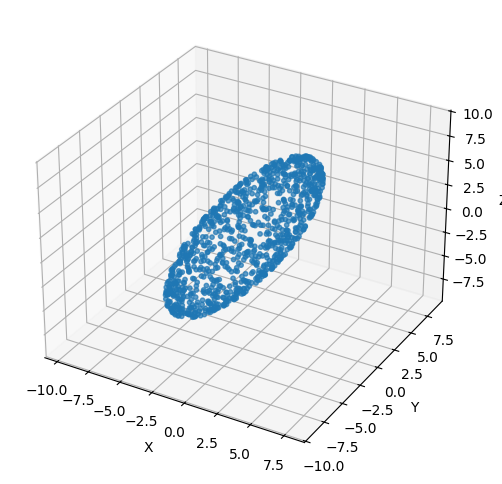

In [95]:
from mpl_toolkits.mplot3d import Axes3D

nsamp = 1000
axes_lengths = [2, 10, 5]
rcenter = 1.0
points = generate_ellipsoid_points(nsamp, axes_lengths, rcenter=rcenter)

# Visualize the generated points

# 3D visualization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.7, s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set appropriate axis bounds
center = points.mean(axis=0)
radius = max(axes_lengths)
ax.set_xlim([center[0]-radius, center[0]+radius])
ax.set_ylim([center[1]-radius, center[1]+radius])
ax.set_zlim([center[2]-radius, center[2]+radius])

ax.grid(True)

Now we can put our manifold capacity tools to use. In the cells below we'll generate some ellipsoids of varying dimension, embed them into a fixed high-dimensional space, compute the manifold capacity/dimension, and look at how these quantities reflect the ellipsoid's true dimension. **NOTE**: the manifold capacity code expects to receive a list of point clouds $[p_1,\ldots,p_k]$ with shapes $p_i \in \mathbb{R}^{N\times n_\text{samples}}$, so you'll need to tranpose the point clouds we generate with our functions.

#### **FILL IN CODE**

In [99]:
ambient_dim = 100
ellips_dims = [2,4,6,8,10,15]
axes_lengths = [d*[1] for d in ellips_dims]  # just do spheres; feel free to change this
nsamples_per = 500
rcenter = 1.0

point_clouds = []
center_norms = []
for edim,ax_lengths in zip(ellips_dims,axes_lengths):
    # generate points
    points = generate_ellipsoid_points(nsamples_per, ax_lengths, rcenter=rcenter, radius=1.0)

    # embed in a ambient_dim space
    points = embed_to_dim(points, ambient_dim)
    center_norms.append(np.linalg.norm(points.mean(axis=0)))

    # add to the point cloud list (careful about the shape!)
    point_clouds.append(points.T)

alphas, Rs, Ds = compute_manifold_quantities(point_clouds, kappa=0, num_t_samples=300)

Text(0, 0.5, 'Mean Field Radius $R_M$')

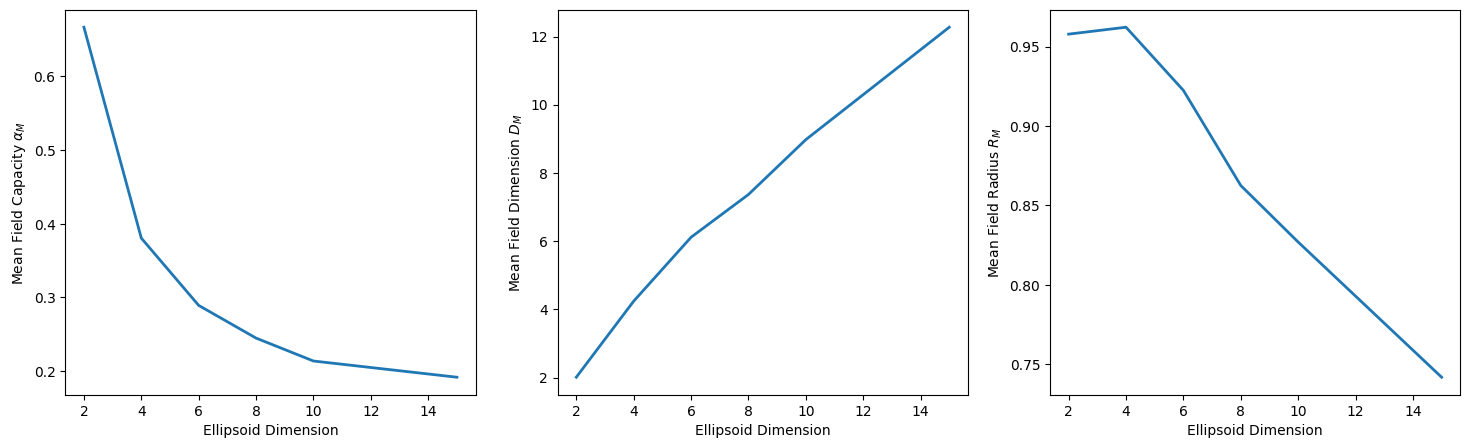

In [100]:
fig,axes = plt.subplots(1,3,figsize=(18,5))

plt.sca(axes[0])
plt.plot(ellips_dims, alphas, lw=2)
plt.xlabel('Ellipsoid Dimension')
plt.ylabel('Mean Field Capacity $\\alpha_M$')

plt.sca(axes[1])
plt.plot(ellips_dims, Ds, lw=2)
plt.xlabel('Ellipsoid Dimension')
plt.ylabel('Mean Field Dimension $D_M$')

plt.sca(axes[2])
plt.plot(ellips_dims, Rs, lw=2)
plt.xlabel('Ellipsoid Dimension')
plt.ylabel('Mean Field Radius $R_M$')

#### **Exercise**
Try varying a few parameters and exploring how the mean-field capacity, radius, and dimension change. A few things to consider

1. Does manifold capacity $\alpha_M$ vary in an intuitive way as you change vary the ellipsoid dimension and the ambient dimension?

2. How is the number of samples per manifold vs. the ambient dimension reflected in the "accuracy" of the computed dimension/radius (relative to ground truth)?

3. Are $R_M$/$D_M$ systematically over/underestimated? Under what conditions?